# Semantic Image Segmentation 

This notebook explores one of the key tasks in computer vision: **semantic image segmentation**.  
The goal is to train a neural network that classifies every pixel in an image into a semantic category (e.g., road, car, pedestrian, vegetation).  
We will use the **KITTI Segmentation Dataset** for training and evaluation.

---

##  Notebook Structure

1. **Introduction & Dataset**
   - Overview of semantic segmentation
   - KITTI dataset setup (images + semantic labels)

2. **Preprocessing**
   - Label encoding (RGB → class IDs)
   - Conversion to segmentation maps
   - Normalization of image data

3. **TensorFlow Input Pipeline**
   - Parsing and preprocessing samples
   - Dataset creation with batching, shuffling, and prefetching
   - Train–Validation split

4. **Model Architecture**
   - U-Net encoder and decoder
   - Model assembly (input → encoder → decoder → softmax output)

5. **Training**
   - Compilation (optimizer, loss, metrics)
   - Model training and convergence plots

6. **Evaluation & Inference**
   - Loading pretrained model
   - Running predictions
   - Converting segmentation maps back to RGB encoding
   - Visualizing results

---

##  Learning Objectives
- Understand the pipeline of semantic segmentation.
- Learn how to prepare datasets for pixel-wise classification.
- Build and train a U-Net model with TensorFlow/Keras.
- Evaluate segmentation performance using **Mean IoU**.
- Visualize predictions in RGB color-coded format.

---


1. Import necessary libraries

In [1]:
# General utilities
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
import random
import glob

# Numerical & plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

### **TensorFlow & Keras (deep learning)**

* **`import tensorflow as tf`** → TensorFlow is the deep learning framework.
* **`from tensorflow.keras.models import Model`** → lets you build custom neural network models.
* **`from tensorflow.keras.layers import ...`** → different building blocks for neural networks:

  * `Input` → starting point for model data.
  * `Dense` → fully connected layer.
  * `Conv2D`, `Conv2DTranspose` → convolution layers (extract features, upsample images).
  * `MaxPooling2D` → reduces image size to keep important features.
  * `BatchNormalization` → stabilizes and speeds up training.
  * `Dropout` → randomly drops neurons to prevent overfitting.
  * `Activation` → applies activation functions like ReLU, sigmoid, etc.
  * `Concatenate` → joins multiple feature maps together.


In [2]:
# TensorFlow & Keras (deep learning)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

from segmentation_utils.metrics import SparseMeanIoU

random.seed(1)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

2025-09-30 19:07:52.806246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 19:07:52.978041: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 19:07:53.015202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-09-30 19:07:53.015220: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

We’ll be working with the [KITTI Segmentation Dataset](http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015), which contains 200 manually annotated images. The RGB images can be found in `datasets/kitti/image_2`, while their corresponding semantic labels are stored in `datasets/kitti/semantic_rgb`. This dataset will serve as the basis for training a deep learning model for semantic segmentation.

In the next step, we extract the file paths for both the images and labels, organize them into lists, and then shuffle the dataset.


In [3]:
images_path_train = "datasets/kitti/image_2"
labels_path_train = "datasets/kitti/semantic_rgb"

# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

print(images_path_train[0])
print(labels_path_train[0])

datasets/kitti/image_2/000033_10.png
datasets/kitti/semantic_rgb/000033_10.png


Visualize images and Label with matplotlib

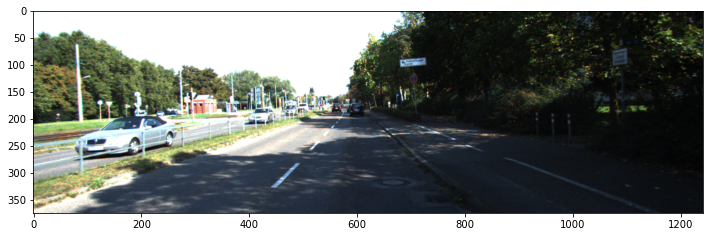

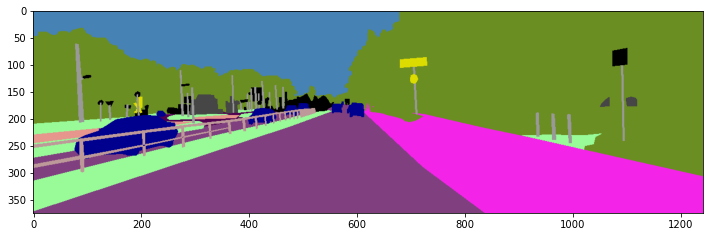

In [4]:
plt.imshow(plt.imread(images_path_train[100]))
plt.show()

plt.imshow(plt.imread(labels_path_train[100]))
plt.show()

## Colar Class Association
To make the segmentation labels easier to interpret, the dataset uses color-coded masks. Each semantic class is represented by a specific RGB color, and this mapping is defined in a dictionary. The dictionary links an RGB triplet to a class ID, and each class ID corresponds to a semantic category such as Road, Sidewalk, or Person. This way, the colors in the label images directly indicate which pixel belongs to which class.

In [5]:
rgb_to_class_id = {
    (128, 64, 128): 0,  # Road
    (244, 35, 232): 1,  # Sidewalk
    (250, 170, 160): 2,  # Parking
    (230, 150, 140): 3,  # Tail track
    (220, 20, 60): 4,  # Person
    (255, 0, 0): 5,  # Rider
    (0, 0, 142): 6,  # Car
    (0, 0, 70): 7,  # Truck
    (0, 60, 100): 8,  # Bus
    (0, 80, 100): 9,  # On Rails
    (0, 0, 230): 10,  # Motorcycle
    (119, 11, 32): 11,  # Bicycle
    (0, 0, 90): 12,  # Caravan
    (0, 0, 110): 13,  # Trailer
    (70, 70, 70): 14,  # Building
    (102, 102, 156): 15,  # Wall
    (190, 153, 153): 16,  # Fence
    (180, 165, 180): 17,  # Guard Rail
    (150, 100, 100): 18,  # Bridge
    (50, 120, 90): 19,  # Tunnel
    (153, 153, 153): 20,  # Pole
    (220, 220, 0): 21,  # Traffic sign
    (250, 170, 30): 22,  # Traffic light
    (107, 142, 35): 23,  # Vegetation
    (152, 251, 152): 24,  # Terrain
    (70, 130, 180): 25,  # Sky
    (81, 0, 81): 26,  # Ground
    (111, 74, 0): 27,  # Dynamic
    (20, 20, 20): 28,  # Static
    (0, 0, 0): 29,  # None
}

## Task: Convert RGB Label Images into Segmentation Maps

Neural networks cannot directly process color-coded label images. Therefore, we need to transform the __RGB color encoding__ into a __segmentation map__, where each pixel is represented by its class ID.  

The figure below illustrates three different ways of representing classes in semantic segmentation. For simplicity, consider an example with 3 classes and an image size of $4 \times 4$:

![illustration](assets/2025-09-28_15-39.png)

- **Color encoding**: Each semantic class is mapped to a specific RGB triplet. Shape: $4 \times 4 \times 3$  
- **Segmentation map**: Each pixel is assigned an integer representing its class ID. Shape: $4 \times 4 \times 1$  
- **One-hot encoding**: Each pixel is represented by a one-hot vector of class membership. Shape: $4 \times 4 \times 3$  

For this assignment, we will use the __segmentation map__ representation, since it is both simple and memory efficient.  

---

### Step-by-Step Instructions

1. **Initialize the segmentation map**  
   Start with a zero tensor of shape `[height, width]` with data type `tf.uint8`.  

2. **Loop through the class dictionary**  
   For each `(color, class_id)` entry in the mapping:  
   - Compare each pixel in the label image with the RGB color using `tf.equal()`.  
   - Apply `tf.reduce_all(..., axis=-1)` to create a boolean mask of matching pixels.  

3. **Update the segmentation map**  
   Use `tf.where` to replace pixel values:  
   - Where the mask is `True`, assign the `class_id` (casted to `tf.uint8`).  
   - Where the mask is `False`, keep the existing value of the segmentation map.  

4. **Expand dimensions**  
   After processing all colors, add an extra axis at the end using `tf.expand_dims()`, converting the shape from `[height, width]` to `[height, width, 1]`.  

Following these steps will yield a segmentation map where each pixel is represented by an integer class ID instead of an RGB triplet. This representation is the input format required for training the neural network.

**complete calculation** for a single 4×4 RGB image converting to a segmentation map.

### Sample 4x4 RGB Image to Segmentation Map

Given a 4×4 RGB image:

$$
I = 
\begin{bmatrix}
[255,0,0] & [0,255,0] & [0,0,255] & [255,0,0] \\
[0,255,0] & [255,0,0] & [0,0,255] & [0,255,0] \\
[0,0,255] & [0,0,255] & [255,0,0] & [0,255,0] \\
[255,0,0] & [0,255,0] & [0,0,255] & [255,0,0]
\end{bmatrix}
$$

RGB to Class ID mapping:

$$
\{ [255,0,0] \to 0, \; [0,255,0] \to 1, \; [0,0,255] \to 2 \}
$$

The resulting segmentation map:

$$
S =
\begin{bmatrix}
0 & 1 & 2 & 0 \\
1 & 0 & 2 & 1 \\
2 & 2 & 0 & 1 \\
0 & 1 & 2 & 0
\end{bmatrix}
$$

After adding an extra dimension:

$$
S \in \mathbb{Z}^{4 \times 4 \times 1}
$$

Each pixel of the original 4×4×3 color-encoded image is now replaced with its integer class ID, forming the segmentation map.




In [6]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an image with the RGB class encoding into a class map.

    Argument:
    image -- tf.tensor of shape [heigh, width, 3] which contains for each pixel a tuple of (R, G, B) values.

    Returns:
    class_map -- tf.tensor of shape [heigh, width, 1] which contains for each pixel a single integer that represents a class
    """

    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in rgb_to_class_id.items():
        mask = tf.reduce_all(tf.equal(image, color), axis=-1)

        # upadate the segmentation map using tp.where

        segmentation_map = tf.where(
            condition=mask,
            x=tf.cast(class_id, tf.uint8),  # assign class_id where the condtion is True
            y=segmentation_map,  # keep the current value otherwise
        )

    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, axis=-1)

    return segmentation_map

## Test the `convert_rgb_encoding_to_segmentation_map`

[25 23 20 29 21 14  6  1  0 16 24 26  3]


2025-09-30 19:08:00.977360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-09-30 19:08:00.977537: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-09-30 19:08:00.977566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2025-09-30 19:08:00.978771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


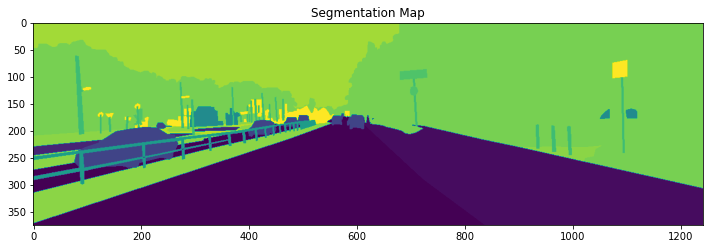

In [7]:
img = tf.image.decode_image(tf.io.read_file(labels_path_train[100]), channels=3)
img = tf.image.resize(img, [375, 1242], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
img = convert_rgb_encoding_to_segmentation_map(img, rgb_to_class_id)
y, idx = tf.unique(tf.reshape(img, -1))
print(y.numpy())


plt.imshow(img)
plt.title("Segmentation Map")
plt.show()

## Building TensorFlow input pipeline

We'll walk through how to set up an efficient input pipeline for an image segmentation dataset. To achieve this, we'll make use of the [tf.data](https://www.tensorflow.org/guide/data) API, which allows us to create a smooth and scalable data pipeline that can easily connect to the TesnsorFlow model we'll build later.

## Parsing Samples from the Dataset

Each dataset entry contains an image and its corresponding label. To process them, we will implement the `parse_sample` function. This function performs the following steps:

1. Read the image file and the label file from their respective file paths.
2. Decode both files as PNG images with three channels (RGB).
3. Resize all images and labels to a fixed resolution of **368 × 1248**.

   * Images are resized using bilinear interpolation.
   * Labels are resized using nearest-neighbor interpolation.
4. Convert the resized image back to the `uint8` data type.
5. Transform the label image into a segmentation map using the `convert_rgb_encoding_to_segmentation_map` function.


In [8]:
def parse_sample(image_path, label_path):
    """
    Argument:
    image_path -- String which contains the path to the camera image
    label_path -- String which contains the path to the label image

    Returns:
    image_rgb -- tf.Tensor of size [368, 1248, 3] containing the camera image
    label_segmentation_map -- tf.Tensor of size [368, 1248, 1] containing the segmentation map
    """
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels=3)
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels=3)

    # Resize all images and labels to a uniform size, because some images in the dataset have different sizes
    image_rgb = tf.image.resize(
        image_rgb, [368, 1248], method=tf.image.ResizeMethod.BILINEAR
    )  # do not modify
    label_rgb = tf.image.resize(
        label_rgb, [368, 1248], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )  # do not modifly

    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8)

    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(
        label_rgb, rgb_to_class_id
    )
    return image_rgb, label_segmentation_map

### Test parse_sample

In [9]:
image, label = parse_sample(images_path_train[0], labels_path_train[0])
print("Image Shape:", image.shape)
print("Label Shape:", label.shape)
print(image[0, 0, :].numpy())
print(label[0, 0, :].numpy())

Image Shape: (368, 1248, 3)
Label Shape: (368, 1248, 1)
[146 221 250]
[23]


## Data Normalization

To prepare the input images for training, we normalize their pixel values. Normalization rescales the data from its original range of **0–255** to a smaller, standardized range such as **[0, 1]** or **[-1, 1]**. This step helps the machine learning model converge faster and improves training stability.

The normalization process involves:

1. Casting the image from `tf.uint8` to `tf.float32`.
2. Dividing all pixel values by `255.0` to bring them into the range **[0, 1]**.



In [10]:
def normalize(image, label):
    """
    Normalizes the input image from range [0, 255] to [0, 1.0]
    Arguments:
    image -- tf.tensor representing a RGB image with integer values in range [0, 255]
    label -- tf.tensor representing the corresponding segmentation mask

    Returns:
    image -- tf.tensor representing a RGB image with integer values in range [0, 1]
    label -- tf.tensor representing the corresponding segmentation mask
    """
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

## Test Normalize

In [11]:
image, label = parse_sample(images_path_train[0], labels_path_train[0])

print("Not Normalized - Maximum:", np.max(image.numpy()))
print("Not Normalized - Minimum:", np.min(image.numpy()))

image, label = normalize(image, label)

print("Normalized - Maximum", np.max(image.numpy()))
print("Normalized - Minimum", np.min(image.numpy()))

Not Normalized - Maximum: 255
Not Normalized - Minimum: 0
Normalized - Maximum 1.0
Normalized - Minimum 0.0


## Building the Dataset

We will now construct a dataset pipeline using the [tf.data API](https://www.tensorflow.org/guide/data), which is designed to create efficient input pipelines for training. The core component is the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class, which we will configure step by step:

1. **Create the dataset**: Initialize a `tf.data.Dataset` object from a list of file path strings using `from_tensor_slices`.
2. **Shuffle the dataset**: Randomize the order of the samples using the `shuffle` method, and define a suitable `buffer_size`.
3. **Parse the samples**: Apply the `parse_sample` function to each dataset element using `map`. Enable parallel processing with `num_parallel_calls=tf.data.AUTOTUNE`.
4. **Normalize the images**: Apply the normalization function to each parsed sample using `map` again with `num_parallel_calls=tf.data.AUTOTUNE`.
5. **Batch the dataset**: Group samples into mini-batches using the `batch` method and specify the `batch_size`.
6. **Prefetch for efficiency**: Add prefetching to the pipeline using `prefetch` with `buffer_size=tf.data.AUTOTUNE` to improve throughput.

In [12]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200):
    """
    Arguments:
    images_path -- List of Strings which contain pathes for the camera images
    labels_pathh -- List of Strings which contain pathes for the label images

    Returns:
    dataset -- tf.data.Dataset
    """

    # Create tf.data.Dataset from images_path and labels_path, replace both None placeholders
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply data normalization. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)
    # Use prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

## Test create_dataset

In [13]:
test_dataset = create_dataset(images_path_train, labels_path_train)
length = tf.data.experimental.cardinality(test_dataset).numpy()

print(test_dataset)
print("Length:", length)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 368, 1248, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 368, 1248, 1), dtype=tf.uint8, name=None))>
Length: 50


## Creating a Train–Validation Split

Before training, we need to divide the dataset into two parts:

* **Training set**: 70% of the total data
* **Validation set**: 30% of the total data

Start by calculating how many samples belong to the training set based on this ratio. The remaining samples will form the validation set.


In [14]:
# get number of data samples
length = len(images_path_train)

train_size = round(length * 0.7)

print(train_size)

140


Now, we know the `train_size` and we can apply it to class functions `take` and `skip` to split the dataset into `train` and `val` dataset

In [15]:
train = create_dataset(images_path_train[:train_size], labels_path_train[:train_size])
val = create_dataset(images_path_train[train_size:], labels_path_train[train_size:])

## Test Train Val split sizes

In [16]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

Train Dataset Length: 35
Val Dataset Length: 15


## Model Architecture

We will use the **U-Net architecture** for semantic image segmentation. Follow these steps to understand how it will be applied in this assignment:

1. **Identify the architecture**: U-Net is a convolutional neural network originally created for medical image analysis.
2. **Adapt it to our task**: Although it was designed for medical data, we will use it here because it is lightweight and easy to train.
3. **Review the implementation**: low-level details of U-Net is not required here. Instead, read through the provided code to understand how the architecture is built.
4. **Assemble the network**: Later in the assignment, we will use the functions `encoder()` and `decoder()` to put together the U-Net model.
5. **Optional deep dive**: refer to the [U-Net research paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) for more details.


![Sample Architecture](assets/Semantic-Segmentation-Approaches-1024x332.jpeg)  
*Source: [image](https://collab.dvb.bayern/spaces/TUMdlma/pages/73379951/)*


### Encoder

The encoder is the **downsampling path** of the U-Net. Its job is to extract features from the input image while gradually reducing the spatial resolution.

* At each depth, the encoder applies multiple convolutional layers to learn increasingly complex features.
* Batch normalization and dropout can be used to improve training stability and reduce overfitting.
* Max pooling layers downsample the feature maps, compressing spatial information while preserving learned features.
* The outputs of each depth (encoder layers) are stored for later use in the decoder, enabling precise reconstruction.


### Decoder

The decoder is the **upsampling path** of the U-Net. Its role is to reconstruct the segmentation map by restoring spatial resolution.

* It starts from the deepest encoder layer and progressively upsamples the feature maps using transposed convolutions.
* At each step, the decoder concatenates the upsampled feature map with the corresponding encoder output (skip connections). This helps recover fine spatial details lost during downsampling.
* Dropout, batch normalization, and convolutional layers refine the combined features, ensuring accurate segmentation boundaries.
* The decoder produces the final feature maps that lead to the prediction layer.

In [17]:
def encoder(input, udepth, filters1, kernel_size, activation, batch_norm, dropout):
    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            activation=activation,
        )(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            activation=activation,
        )(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def decoder(
    encoder_layers, udepth, filters1, kernel_size, activation, batch_norm, dropout
):
    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(
            filters=filters, kernel_size=kernel_size, strides=(2, 2), padding="same"
        )(t)

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            activation=activation,
        )(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            activation=activation,
        )(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t

## Task: Assemble the U-Net Segmentation Model

To build the complete U-Net, we will combine the encoder and decoder parts of the network and connect them with input and output layers. Follow these steps:

1. **Define the input**: Create a Keras `Input` layer with the specified `input_shape`. This will serve as the entry point of the network.
2. **Build the encoder**: Pass the input tensor to the `encoder()` function to generate the encoder layers. Provide all necessary arguments to match the required configuration.
3. **Build the decoder**: Take the encoder layers as input and pass them to the `decoder()` function. This will reconstruct the spatial details and produce the upsampled feature maps.
4. **Add the prediction layer**: Use a `Conv2D` layer with the number of filters equal to `num_classes`. Feed the output of the decoder into this layer so the final output has the shape `[height, width, num_classes]`.
5. **Apply softmax activation**: Attach an `Activation("softmax")` layer to the prediction logits in order to convert them into class probabilities.
6. **Assemble the model**: Use the Keras functional API to define the final model by specifying the input tensor as `inputs` and the probability output as `outputs` in the `Model()` function.


In [18]:
def getModel(
    input_shape,
    num_classes,
    udepth=5,
    filters1=16,
    kernel_size=(3, 3),
    activation=tf.nn.relu,
    batch_norm=True,
    dropout=0.1,
):
    """
    This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.

    Arguments:
    input_shape -- Input shape of the model as tuple or list
    num_classes -- Number of classes to predict as int
    udepth -- Depth of the network
    filters1 -- Number of filters at the first layer
    kernel_size -- Kernel size for the convolutional operations
    activation -- Type of the Activation function
    batch_norm -- Boolean if batch norm should be applied
    dropout -- Dropout regularization

    Returns:
    segmentation_model -- Keras Model
    """

    ### START CODE HERE ###

    # create input layer
    input_tensor = Input(input_shape)

    # construct encoder
    encoder_layers = encoder(
        input=input_tensor,
        udepth=udepth,
        filters1=filters1,
        kernel_size=kernel_size,
        activation=activation,
        batch_norm=batch_norm,
        dropout=dropout,
    )

    # construct decoder
    reconstruction = decoder(
        encoder_layers=encoder_layers,
        udepth=udepth,
        filters1=filters1,
        kernel_size=kernel_size,
        activation=activation,
        batch_norm=batch_norm,
        dropout=dropout,
    )

    # build final prediction layer
    logits = Conv2D(
        filters=num_classes,
        kernel_size=kernel_size,
        padding="same",
        activation=activation,
    )(reconstruction)

    # apply softmax activation function to the logits
    probabilities = Activation("softmax")(logits)

    # create a Keras model
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)

    ### END CODE HERE ###

    return segmentation_model

### Test: `getModel`

In [19]:
model = getModel(input_shape=[368, 1248, 3], num_classes=30)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 368, 1248,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 368, 1248, 1  448         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 368, 1248, 1  64         ['conv2d[0][0]']                 
 alization)                     6)                                                            

# Model training

Once our model is setup up correctly we can compile it by adding an __optimizer__ to the model, a __loss function__ and we can also add more __metrics__ in order to observe the training progress.

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=[SparseMeanIoU(num_classes=30, name="MIoU")],
)

Now, the training of the model can be evoked by calling the class function `fit`. Note that we will train here only 1 epoch for demonstration. We don't want you to wait several hours for the model to finish. We will use in the next steps a pretrained model which was trained for several hundred steps.

In [21]:
history = model.fit(train, validation_data=val, epochs=3)

Epoch 1/3
35/35 [==============================] - 96s 3s/step - loss: 2.3609 - MIoU: 0.0576 - val_loss: 3.3847 - val_MIoU: 0.0158
Epoch 2/3
35/35 [==============================] - 93s 3s/step - loss: 1.6192 - MIoU: 0.0755 - val_loss: 97.2809 - val_MIoU: 0.0085
Epoch 3/3
35/35 [==============================] - 96s 3s/step - loss: 1.3928 - MIoU: 0.0918 - val_loss: 57.1723 - val_MIoU: 0.0085


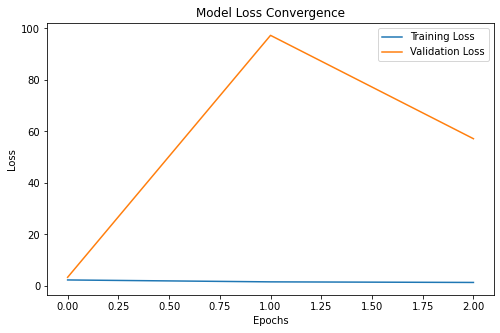

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Convergence")
plt.legend()
plt.show()

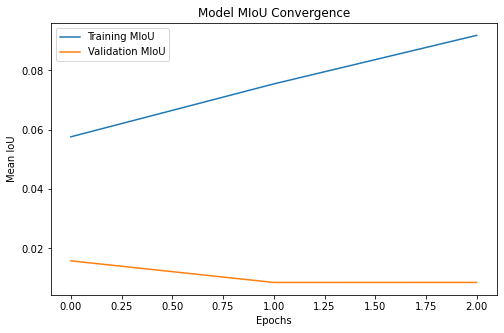

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["MIoU"], label="Training MIoU")
plt.plot(history.history["val_MIoU"], label="Validation MIoU")
plt.xlabel("Epochs")
plt.ylabel("Mean IoU")
plt.title("Model MIoU Convergence")
plt.legend()
plt.show()

# Model Loading

The pretrained model can be loaded into the existing model by using the function `load_weights`. This model was trained much longer, Hence the performance is much better.

In [24]:
model.load_weights("segmentation_utils/pretrained_model/model")

# Model inference
We can now perform __inference__ on that pretrained model by loading a sample from the dataset and use the model's `predict` function.

In [25]:
image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
image, label = normalize(image, label)

# add batch dimension
image = tf.expand_dims(image, axis=0)

probabilities = model.predict(image)

print("Input Image Shape:  ", image.shape)
print("Probabilities Shape:", probabilities.shape)

1/1 [==============================] - 0s 492ms/step
Input Image Shape:   (1, 368, 1248, 3)
Probabilities Shape: (1, 368, 1248, 30)


## Compute Segmentation Map from One-Hot Encoding

The network outputs predictions in the shape `[batch_size, height, width, num_classes]`. Each pixel is represented by a one-hot encoding vector, where the values indicate the predicted probabilities for each class.

To convert this into a segmentation map:

1. **Select the most probable class per pixel**: For each pixel, identify the class with the highest probability. This reduces the shape from `[batch_size, height, width, num_classes]` to `[batch_size, height, width, 1]`.
2. **Remove unnecessary dimensions**: Since the batch size is 1, eliminate the batch dimension to obtain a final shape `[height, width]` suitable for visualization.

This process produces a segmentation map where each pixel is assigned its predicted class.

In [26]:
# compute the segmentation map
prediction = tf.argmax(probabilities, axis=-1)
# get rid of the batch dimension
prediction = tf.squeeze(prediction)

# Test: Compute segmentation map
print("Prediction shape:", prediction.shape)

Prediction shape: (368, 1248)


### Plot of the segmentation map
Now we can simply use matplotlib's `imshow` function to visualize the predictions and the label.

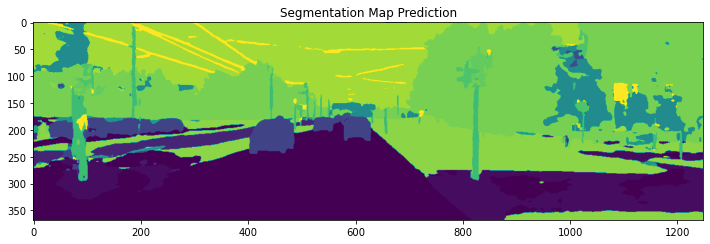

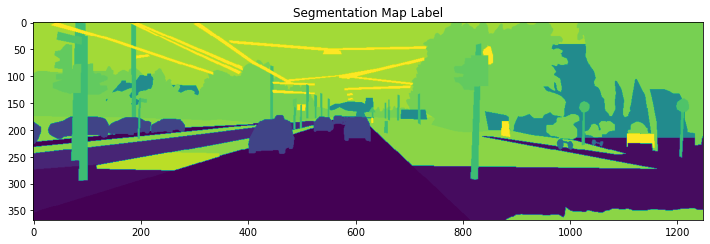

In [27]:
plt.figure()
plt.imshow(prediction)
plt.title("Segmentation Map Prediction")
plt.show()

plt.figure()
plt.imshow(label)
plt.title("Segmentation Map Label")
plt.show()

### Task: Convert Segmentation Map to RGB Encoding

Previously, we transformed the **RGB-encoded labels** into a **segmentation map**. Now, we will reverse this process to convert a segmentation map back into an **RGB image** for easier visualization.

To perform this conversion:

1. **Iterate over class-color pairs**: For each class in your dataset, retrieve its corresponding RGB color.
2. **Assign colors to pixels**: For every pixel in the segmentation map that belongs to a given class, set its value in the output RGB image to the corresponding color.
3. **Build the final RGB image**: Repeat this for all classes so that the segmentation map is fully converted into a visually meaningful RGB representation.

This results in an RGB image where each class is represented by its assigned color, making it easier to interpret the segmentation output.


In [28]:
def segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id):
    """
    Converts the segmentation map into a RGB encoding

    Arguments:
    segmentation_map -- Numpy ndArray of shape [height, width, 1]
    rgb_to_class_id -- Dictionary which contains the association between color and class ID

    Returns:
    rgb_encoding -- Numpy ndArray of shape [height, width, 3]
    """

    rgb_encoding = np.zeros(
        [segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=np.uint8
    )

    ### START CODE HERE ###
    for color, class_id in rgb_to_class_id.items():
        rgb_encoding[segmentation_map == class_id] = color

    ### END CODE HERE ###
    return rgb_encoding

### Test: `segmentation_map_to_rgb_encoding`

RGB Encoding shape: (368, 1248, 3)


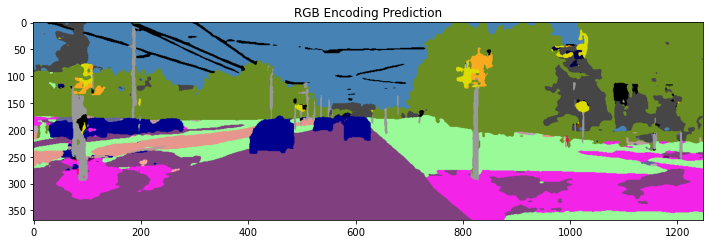

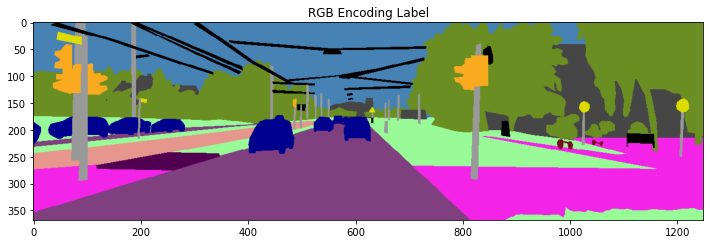

In [29]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

print("RGB Encoding shape:", rgb_encoding.shape)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()


rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()

In [30]:
# References

#### Kitti Dataset

@ARTICLE{Alhaija2018IJCV,
  author = {Hassan Alhaimja and Siva Mustikovela and Lars Mescheder and Andreas Geiger and Carsten Rother},
  title = {Augmented Reality Meets Computer Vision: Efficient Damta Generation for Urban Driving Scenes},
  journal = {International Journal of Computer Vision (IJCV)},
  year = {2018}
}

U-Net Architecture

@article{DBLP:journals/corr/RonnebergerFB15,
  author    = {Olaf Ronneberger and
               Philipp Fischer and
               Thomas Brox},
  title     = {U-Net: Convolutional Networks for Biomedical Image Segmentation},
  journal   = {CoRR},
  volume    = {abs/1505.04597},
  year      = {2015},
  url       = {http://arxiv.org/abs/1505.04597},
  archivePrefix = {arXiv},
  eprint    = {1505.04597},
  timestamp = {Mon, 13 Aug 2018 16:46:52 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/RonnebergerFB15.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}